## Main Mega Project File
Analisis Tweet yang mengandung berbagai kata dengan konteks islam. Tujuan awal saya membuat file ini adalah untuk mengetahui sentiment tweet yang ada pada twitter terhadap kata muslim. Selain itu, saya juga bertujuan untuk mencari kata yang sering dipadankan pada tweet berbau islam. Tujuan utama saya adalah ingin mengetahui seberapa tinggi / sering islam dibicarakan, dan bagaimana sentiment yang ada pada tweet tersebut. Akan tetapi, pada kesempatan awal ini, saya hanya akan menggunakan sekitar 20000 data dengan keywords muslim.

Saya harap dengan adanya analisis ini, saya dapat berbagai pengetahuan mengenai pandangan dunia (khususnya warga twitter) terhadap muslimin / islam. Saya tahu bahwa data yang saya gunakan tergolong kecil, namun saya berniat untuk menambah datanya sedikit demi sedikit. Juga, semoga saya dapat menemukan celah dan "something" untuk dieksekusi.

Pada file ini, kita akan melakukan beberapa hal terhadap data yang sudah kita scrapping. Data yang akan digunakan adalah data dari twit sebanyak 20000 dari twitter menggunakan api twint. 20000 baris data tersebut merupakan data dengan kandungan kata "muslim" dan merupakan 20000 twit terakhir.

Perlu diingat juga, bahwa pada saat ini kita masih melakukan analisis hanya kepada tweet dengan bahasa english, mungkin nanti akan dikembangkan kembali. Akan tetapi, untuk saat ini, kita masih membatasi hal tersebut

### Data Cleaning
Data akan dibersihkan terlebih dahulu karena kita belum membutuhkan kebanyakan kolom yang tersedia. Seperti kolom id, urls, dsb. Pada proses ini saya akan membagi-baginya menjadi beberapa fungsi agar lebih mudah untuk dilihat.

In [1]:
# unhash kode program ini jika belum mempunyai stopwords atau vader_lexicon sesuai kebutuhan (english)

import nltk 
# nltk.download('stopwords')
# nltk.download('vader_lexicon')

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import itertools
import collections

from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import PorterStemmer, WordNetLemmatizer

warnings.filterwarnings('ignore')
%matplotlib inline

sns.set_style("whitegrid")

In [3]:
# fungsi ini berguna untuk membuang kolom sesuai dengan kebutuhan kita

def drop_columns(df):
    base_col = [
        'created_at', 
        'date', 
        'time', 
        'username', 
        'tweet', 
        'language', 
        'replies_count', 
        'retweets_count',
        'likes_count',
        'hashtags',
        'user_id',
        'conversation_id'
        
    ]
    drop_col = diff(df.columns, base_col)
    df_drop = df.drop(drop_col, axis = 1)
    return df_drop

In [4]:
#fungsi ini berfungsi sebagai pencari difference antar 2 list

def diff(list1, list2):
    c = set(list1).union(set(list2))  # or c = set(list1) | set(list2)
    d = set(list1).intersection(set(list2))  # or d = set(list1) & set(list2)
    return list(c - d)

In [5]:
#fungsi yang akan memfilter dataset untuk bahasa tertentu saja

def lang_only(df, lang):
    df_lang = df[df['language'] == lang]
    return df_lang

In [6]:
#fungsi ini berfungsi untuk splitting data pada kolom created_at karena kita mungkin butuh tempat dimana  tweet tersebut dijalankan

def created_at_split(df):
    df_splitted = df.copy()
    df_splitted['region'] = df_splitted['created_at'].apply(lambda x : x.split()[2])
    return df_splitted

In [7]:
#Fungsi ini berguna untuk menjalankan fungsi-fungsi di atas tersebut

def pipeline(df):
    df = drop_columns(df)
    df = lang_only(df, 'en')    
    df = created_at_split(df)
    return df

In [8]:
cwd = os.getcwd()
data_path = os.path.join(cwd, 'databases', 'store_twit_islam.csv')

df = pd.read_csv(data_path)
df_copy = df.copy()

df_copy.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1.624410e+18,1.624410e+18,2023-02-11 21:23:46 SE Asia Standard Time,2/11/2023,21:23:46,700,1.523340e+18,yozora_glory,Waqar,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'xavierjp__', 'name': 'Xavier...",NaN,NaN,NaN,NaN
1,1.624410e+18,1.624380e+18,2023-02-11 21:23:46 SE Asia Standard Time,2/11/2023,21:23:46,700,3.293665e+09,svensktfornuft,Sunt Förnuft,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'J1965Jnsson', 'name': 'Rober...",NaN,NaN,NaN,NaN
2,1.624410e+18,1.624410e+18,2023-02-11 21:23:42 SE Asia Standard Time,2/11/2023,21:23:42,700,1.540170e+18,22liabirulangit,22Liabirulangit,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1.624410e+18,1.624360e+18,2023-02-11 21:23:42 SE Asia Standard Time,2/11/2023,21:23:42,700,1.552050e+18,mimii_sf,-,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'hdjakshzksbz', 'name': '✌', ...",NaN,NaN,NaN,NaN
4,1.624410e+18,1.624390e+18,2023-02-11 21:23:41 SE Asia Standard Time,2/11/2023,21:23:41,700,1.389540e+18,livetvarbedre,Det var bedre før pesten islam i DK.,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Ikrmnsg', 'name': '🇩🇰 DANISH...",NaN,NaN,NaN,NaN


In [9]:
df_copy.shape

(217943, 36)

In [10]:
df_copy.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [11]:
df['language'].unique()

array(['en', 'sv', 'in', 'fr', 'da', 'qme', 'tl', 'tr', 'und', 'nl', 'ar',
       'hi', 'et', 'de', 'ur', 'ja', 'bn', 'es', 'zxx', 'ca', 'fa', 'pt',
       'ro', 'ht', 'is', 'no', 'qht', 'eu', 'ps', 'qst', 'qam', 'pl',
       'art', 'fi', 'lt', 'cy', 'it', 'ru', 'gu', 'sl', 'hu', 'cs', 'mr',
       'sd', 'vi', 'ta', 'ml', 'kn', 'my', 'am', 'ko', 'te', 'zh', 'lv',
       'ckb', 'th', 'sr', 'uk', 'el', 'iw', 'ne', 'dv', 'si'],
      dtype=object)

<AxesSubplot: xlabel='count', ylabel='language'>

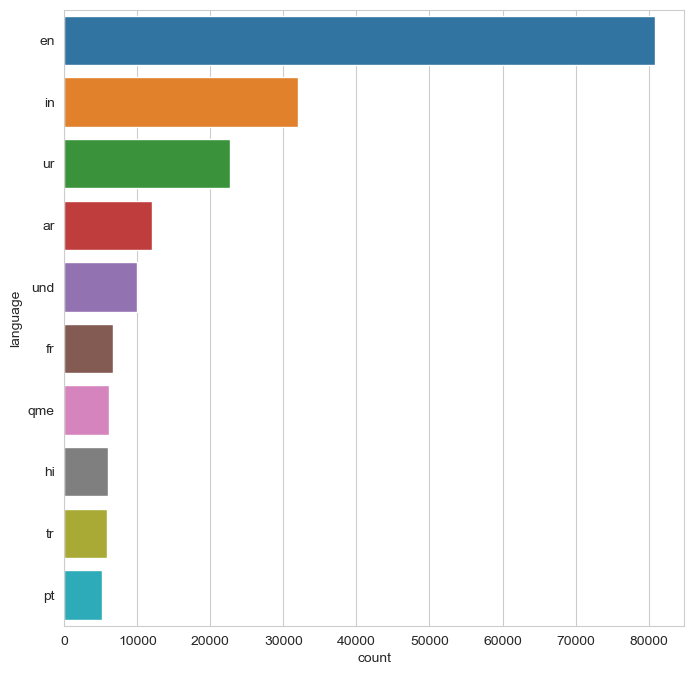

In [12]:
fig, ax = plt.subplots(1,1, figsize = (8,8))

sns.countplot(data = df, y = 'language', ax = ax, order = df['language'].value_counts().iloc[:10].index)

Berdasarkan plot tersebut, kita mungkin hanya memerlukan bahasa en saja mengingat mungkin bahasa tersebut yang mungkin dapat dibaca. Selain itu, bahasa tersebut menunjukkan banyak jumlah yang timpang dengan yang lain. Seharusnya kita dapat langsung memfilter dari twint sendiri, namun sepertinya ada bug di library twint tersebut.

In [13]:
df_copy[df_copy.duplicated()]

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest


Terlihat bahwa tidak ada tweet yang terduplikasi

In [14]:
df_copy = pipeline(df_copy)

In [15]:
df_copy.head()

,conversation_id,created_at,date,time,user_id,username,tweet,language,replies_count,retweets_count,likes_count,hashtags,region
0,1.624410e+18,2023-02-11 21:23:46 SE Asia Standard Time,2/11/2023,21:23:46,1.523340e+18,yozora_glory,@xavierjp__ Not to make any excuses for someon...,en,0,0,0,[],SE
5,1.624220e+18,2023-02-11 21:23:41 SE Asia Standard Time,2/11/2023,21:23:41,1.607640e+18,sharifu35550584,@Muskanr98100617 Ok Send me your personal numb...,en,0,0,0,[],SE
7,1.623750e+18,2023-02-11 21:23:40 SE Asia Standard Time,2/11/2023,21:23:40,1.327260e+18,bruhmp416,@Sofya52036368 @Cobratate Men thank Andrew Tat...,en,0,0,0,[],SE
9,1.624410e+18,2023-02-11 21:23:36 SE Asia Standard Time,2/11/2023,21:23:36,9.178350e+17,raythinking,"Org. Religion was built to benefit the elite, ...",en,1,0,0,[],SE
10,1.624410e+18,2023-02-11 21:23:35 SE Asia Standard Time,2/11/2023,21:23:35,1.428350e+18,taha_wajahat,Every Muslim was given Islam in the form of Qu...,en,0,0,0,[],SE


In [16]:
df_copy.region.unique()

array(['SE'], dtype=object)

Berdasarkan informasi di atas, kita dapat mengetahui bahwa data tweet yang kita gunakan hanya terdiri dari user yang ada di southeast

### Analysis Tweet
Pada bagian ini, akan dilakukan beberapa visualisasi dan analisis dari tweet-tweet yang telah kita scrap.

In [17]:
def highest_tweets(df_copy, col, limit):
    df_copy_sum = pd.DataFrame(df_copy.groupby('username')[[col, 'user_id']].sum()).sort_values(by = [col], ascending = False)
    
    highest_tweet = df_copy_sum.iloc[:limit]

    sns.barplot(data = highest_tweet, y = highest_tweet.index, x = col, orient = 'h')
    
    return highest_tweet

In [18]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [19]:
def words_count(df):
    words = []
    
    #menghapus segala bentuk huruf yang tidak diinginkan
    df['tweet'] = df['tweet'].apply(lambda x : remove_url(x))

    
    #mengubah tiap kata pada tweet menjadi huruf kecil
    df['tweet'] = df['tweet'].apply(lambda x : x.lower())
    
    #melakukan splitting word pada tiap tweet 
    words.append(df_copy['tweet'].apply(lambda x : x.split()))
    
    words = list(np.array(words).flatten())
    
    all_words = itertools.chain(*words)
    
    count_worlds = collections.Counter(all_words)
    
    return count_worlds


In [34]:
def lem(a):
    p = nltk.WordNetLemmatizer()
    b = []
    for line in a:

        split_line = line.split(' ')
        length=len(split_line)
        new_line = []

        for word in range(length):
            if word == 0:
                new_line.append(str(p.lemmatize(split_line[word], pos="v")))
            else:
                new_line[0] = new_line[0] + ' ' + (str(p.lemmatize(split_line[word], pos="v")))

        b.append(new_line[0])

    return b

In [38]:
df_copy['tweet'] = df_copy['tweet'].apply(lambda x : remove_url(x))
df_copy['lemmed_tweet'] = lem(df_copy.tweet)
df_copy.head()

,conversation_id,created_at,date,time,user_id,username,tweet,language,replies_count,retweets_count,likes_count,hashtags,region,lemmed_tweet
0,1.624410e+18,2023-02-11 21:23:46 SE Asia Standard Time,2/11/2023,21:23:46,1.523340e+18,yozora_glory,xavierjp not to make any excuses for someone a...,en,0,0,0,[],SE,xavierjp not to make any excuse for someone ap...
5,1.624220e+18,2023-02-11 21:23:41 SE Asia Standard Time,2/11/2023,21:23:41,1.607640e+18,sharifu35550584,muskanr98100617 ok send me your personal numbe...,en,0,0,0,[],SE,muskanr98100617 ok send me your personal numbe...
7,1.623750e+18,2023-02-11 21:23:40 SE Asia Standard Time,2/11/2023,21:23:40,1.327260e+18,bruhmp416,sofya52036368 cobratate men thank andrew tate ...,en,0,0,0,[],SE,sofya52036368 cobratate men thank andrew tate ...
9,1.624410e+18,2023-02-11 21:23:36 SE Asia Standard Time,2/11/2023,21:23:36,9.178350e+17,raythinking,org religion was built to benefit the elite th...,en,1,0,0,[],SE,org religion be build to benefit the elite the...
10,1.624410e+18,2023-02-11 21:23:35 SE Asia Standard Time,2/11/2023,21:23:35,1.428350e+18,taha_wajahat,every muslim was given islam in the form of qu...,en,0,0,0,[],SE,every muslim be give islam in the form of qura...


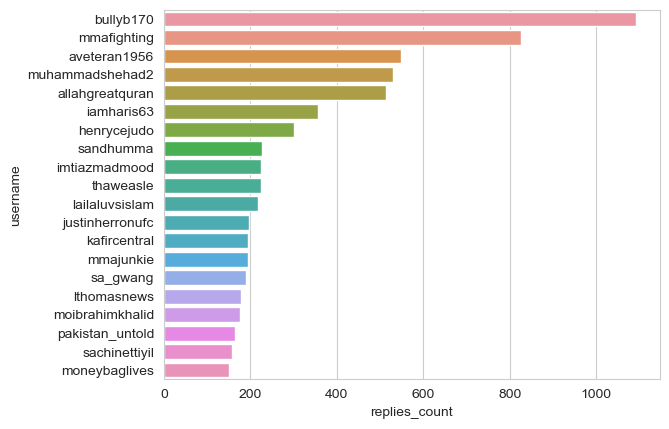

In [21]:
top_user_id = []

top_user_id.append(highest_tweets(df_copy, 'replies_count', 20))

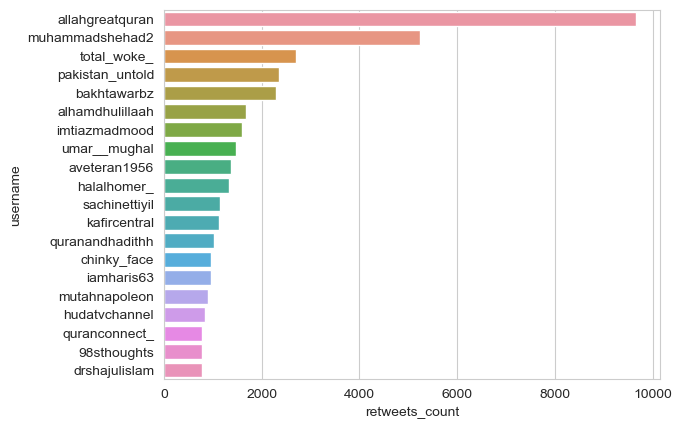

In [22]:
top_user_id.append(highest_tweets(df_copy, 'retweets_count', 20))


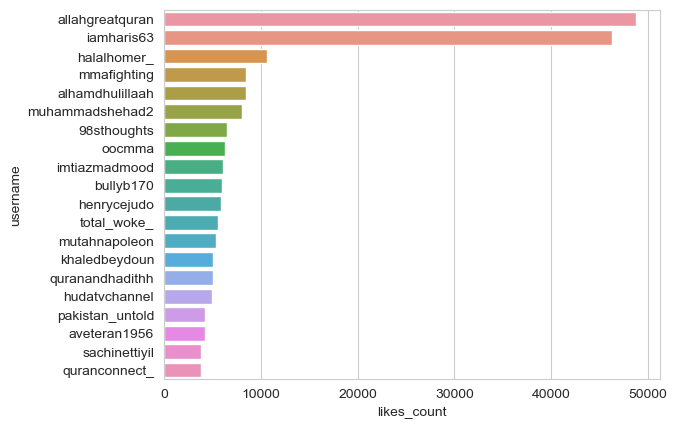

In [23]:
top_user_id.append(highest_tweets(df_copy, 'likes_count', 20))


In [43]:
all_words = words_count(df_copy)
key_words = ['muslims', 'muslim', 'islam', 'quran', 'isis']
common_words = ['would', 'make', 'someone', 'case', 'even', 'say']

stops = list(stopwords.words('english'))
stops += key_words + common_words


In [25]:
main_words = np.array([[word, int(all_words[word])] for word in all_words if word not in stops])
counts = main_words[:, 1].astype('int')

counts

array([  8, 111,   1, ...,   1,   1,   1])

In [26]:
main_words = pd.DataFrame({
    'words' : main_words[:, 0],
    'counts' : counts
})

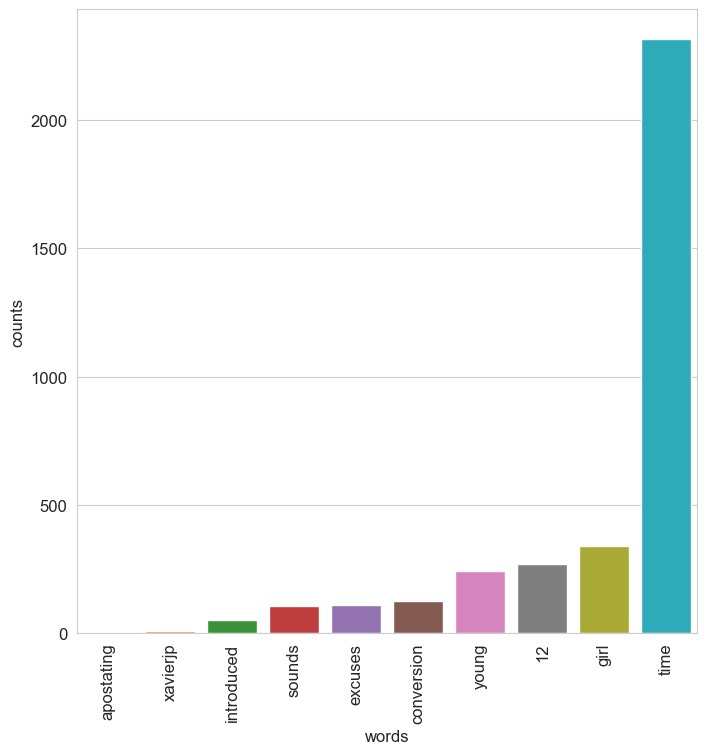

In [52]:
fig, ax = plt.subplots(1,1, figsize = (8,8))

g = sns.barplot(data = main_words[:10].sort_values('counts'), x = 'words', y = 'counts', ax = ax)
g.set_xticklabels(main_words[:10].sort_values('counts')['words'], rotation = 90)

plt.show()
# main_words[:10].sort_values('counts')['words']

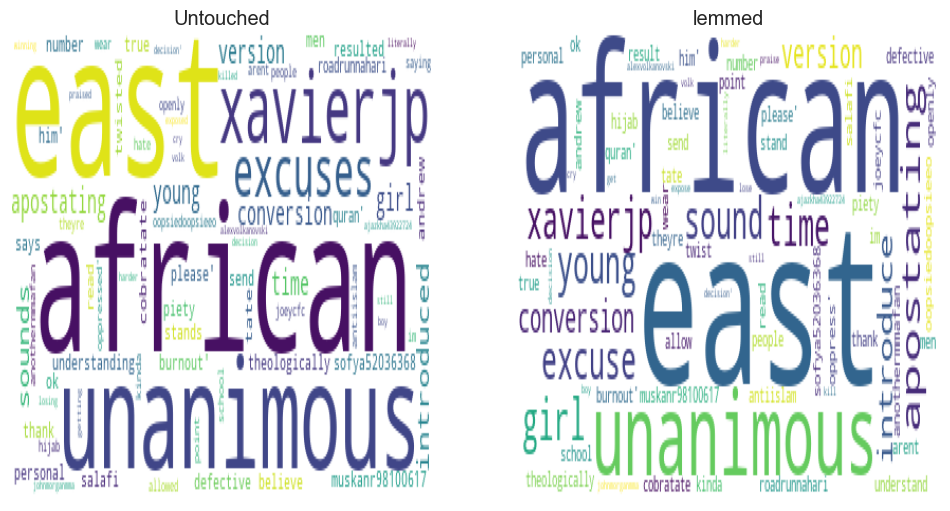

In [44]:
mpl.rcParams['figure.figsize']=(10,10)    
mpl.rcParams['font.size']=12                        
mpl.rcParams['figure.subplot.bottom']=.1 

wordcloud_t = WordCloud(background_color='white',stopwords=stops).generate(str(df_copy['tweet'].values))
wordcloud_t_lemmed = WordCloud(background_color='white',stopwords=stops).generate(str(df_copy['lemmed_tweet'].values))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.imshow(wordcloud_t, aspect="auto")
ax1.title.set_text('Untouched')
ax1.axis('off')

ax2.imshow(wordcloud_t_lemmed, aspect="auto")
ax2.title.set_text('lemmed')
ax2.axis('off')

plt.show()

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import operator

sia = SentimentIntensityAnalyzer()
df_copy["sentiment_score"] = df_copy["tweet"].apply(lambda x: sia.polarity_scores(x)["compound"])
df_copy["sentiment"] = np.select([df_copy["sentiment_score"] < 0, df_copy["sentiment_score"] == 0, df_copy["sentiment_score"] > 0],
                           ['neg', 'neu', 'pos'])

In [ ]:
wordcloud_t_lemmed_good = WordCloud(background_color='white',stopwords=stops).generate(str(df_copy[df_copy['sentiment'] == ]['lemmed_tweet'].values))
wordcloud_t_lemmed_bad = WordCloud(background_color='white',stopwords=stops).generate(str(df_copy['lemmed_tweet'].values))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.imshow(wordcloud_t_lemmed_good, aspect="auto")
ax1.title.set_text('good sentiment')
ax1.axis('off')

ax2.imshow(wordcloud_t_lemmed_bad, aspect="auto")
ax2.title.set_text('bad sentiment')
ax2.axis('off')

plt.show()

In [ ]:
df_copy['sentiment']

In [ ]:
df_copy["sentiment"].value_counts()

In [ ]:
sns.countplot(data = df_copy, x = 'sentiment')

Dari plot tersebut kita tahu bahwa distribusi antara positif tweet dengan negative tweet seimbang. Akan tetapi, perlu diperhatikan juga bahwa hal tersebut tidak 100% akurat, mengingat kita menggunakan model dari package luar, namun ini tetap dapat dijadikan sebagai acuan kita terhadap garis besar tweet.

In [ ]:
# Ini adalah program yang menghitung satu user melakukan tweet berapa kali, dengan username tersebut.

df_most_id = pd.DataFrame(df_copy.groupby(['user_id', 'username'])['user_id'].count())
df_most_id['index'] = df_most_id.index
df_most_id['user_id_counts'] = df_most_id['index'].apply(lambda x : x[0])
df_most_id['username'] = df_most_id['index'].apply(lambda x : x[1])
df_most_id.drop(columns = ['index'], inplace = True)
df_most_id.index = np.arange(len(df_most_id))
df_most_id.rename(columns = {'user_id' : 'user_id_counts', 'user_id_counts' : 'user_id' }, inplace = True)

df_most_id_sorted = df_most_id.sort_values(by = ['user_id_counts'], ascending = False).iloc[:20]
df_most_id_sorted

In [ ]:
df_most_id2 = pd.DataFrame(df_copy.groupby(['user_id', 'sentiment'])['tweet'].count()).sort_values('tweet', ascending = False)
df_most_id2

Berdasarkan table ini, terdapat sebuah fakta menarik bahwa ada user yang melakukan tweet dengan banyak tweet bernilai positif sama dengan tweet bernilai negatif. Hal ini menarik, mengingat user tersebut adalah user yang sama, dan memungkinkan dengan username yang berbeda. Hal ini mungkin mengindikasikan adanya double face pada user-user tersebut.

In [ ]:
df_most_id2['index'] = df_most_id2.index
df_most_id2['user_id'] = df_most_id2['index'].apply(lambda x : x[0])
df_most_id2['sentiment'] = df_most_id2['index'].apply(lambda x : x[1])
df_most_id2.drop(columns = ['index'], inplace = True)
df_most_id2.index = np.arange(len(df_most_id2))
df_most_id2

In [ ]:
df_most_id2 = df_most_id2[df_most_id2['sentiment'] == 'neg']
df_most_id2
# df_most_id2.groupby(['user_id']).count().sort_values('sentiment', ascending = False)

In [ ]:
most_neg_user = df_copy[df_copy['user_id'] == df_most_id2['user_id'].iloc[0]][['tweet', 'sentiment']]
most_neg_user.to_csv(os.path.join('databases', 'most_neg_user.csv'))
most_neg_user

In [ ]:
df_mohammadfahim68 = df_copy[df_copy['username'] == 'mohammadfahim68'][['tweet', 'sentiment']]
df_mohammadfahim68['sentiment'].value_counts()

In [ ]:
df_mohammadfahim68[df_mohammadfahim68['sentiment'] == 'neg']

In [ ]:
df_most_id2